# **Neural network for Windfinder data**
Lennart Petersen

---

**Concept**

*   Predict if weather on next day will be nice for sailing or not
*   Input: weather data of last 120 hours from different locations
*   Output: 1 (good for sailing) or 0 (bad for sailing) -> *Binary classification*





**Dataset**

*   Weather data from 7 locations (only 4 are used)
*   Data from 2016-01-01 to 2019-12-31
*   Measurements several times a day



**Tools**

*   Tensorflow
*   Keras


# **Setup**

In [1]:
#!pip install tensorflow

In [2]:
import numpy as np
import datetime as dt
import math
import glob
import csv
import matplotlib.pyplot as plt
import random
random.seed(42)
np.random.seed(1337)

from keras.utils import plot_model

In [3]:
import tensorflow as tf
print(tf.__version__)

2.4.0


In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
project_folder = '/content/drive/My Drive/Dokumente/windfinder/data_windfinder'
START_DATE = "2016-01-01 00"
END_DATE = "2020-01-01 00"
# definition of nice sailing weather
min_wind_speed = 10
max_wind_speed = 30
min_wind_gust = 10
max_wind_gust = 40
min_temperature = 5
max_temperature = 50

## **Import windfinder data**

In [6]:
# get data from csv files
def get_weatherdata_list(fileID):
  station_files = glob.glob(project_folder + "/weatherdata_" + fileID + "_*.csv")
  station_files.sort()
  print("Weatherdata files:")
  print(station_files)

  weatherdata_list = []
  print("Start reading")
  for i in range (len(station_files)):
    wd = station_files[i]
    with open(wd) as csv_file:
      wd_reader = csv.reader(csv_file, delimiter=';')
      for row in wd_reader:
        if len(row) > 4 and row[0] != "date/time (UTC)": weatherdata_list.append(row)

  print("{} measurements total in {}* files".format(len(weatherdata_list), fileID))
  return weatherdata_list

In [7]:
# get weatherdata
num_locations = 4
weatherdata_list_Kiel_Leuchtturm = get_weatherdata_list("10044N")
weatherdata_list_Skt_Peter_Ording = get_weatherdata_list("10028")
weatherdata_list_Warnemuende_Wetterwarte = get_weatherdata_list("10169")
#weatherdata_list_Port_Said_Airport = get_weatherdata_list("eg3")
#weatherdata_list_Molasses_Reef = get_weatherdata_list("us15")
#weatherdata_list_Renesse_West = get_weatherdata_list("nl22")
weatherdata_list_Hvide_Sande = get_weatherdata_list("06058")

Weatherdata files:
['/content/drive/My Drive/Dokumente/windfinder/data_windfinder/weatherdata_10044N_2016.csv', '/content/drive/My Drive/Dokumente/windfinder/data_windfinder/weatherdata_10044N_2017.csv', '/content/drive/My Drive/Dokumente/windfinder/data_windfinder/weatherdata_10044N_2018.csv', '/content/drive/My Drive/Dokumente/windfinder/data_windfinder/weatherdata_10044N_2019.csv']
Start reading
197524 measurements total in 10044N* files
Weatherdata files:
['/content/drive/My Drive/Dokumente/windfinder/data_windfinder/weatherdata_10028_2016.csv', '/content/drive/My Drive/Dokumente/windfinder/data_windfinder/weatherdata_10028_2017.csv', '/content/drive/My Drive/Dokumente/windfinder/data_windfinder/weatherdata_10028_2018.csv', '/content/drive/My Drive/Dokumente/windfinder/data_windfinder/weatherdata_10028_2019.csv']
Start reading
34566 measurements total in 10028* files
Weatherdata files:
['/content/drive/My Drive/Dokumente/windfinder/data_windfinder/weatherdata_10169_2016.csv', '/con

### Map

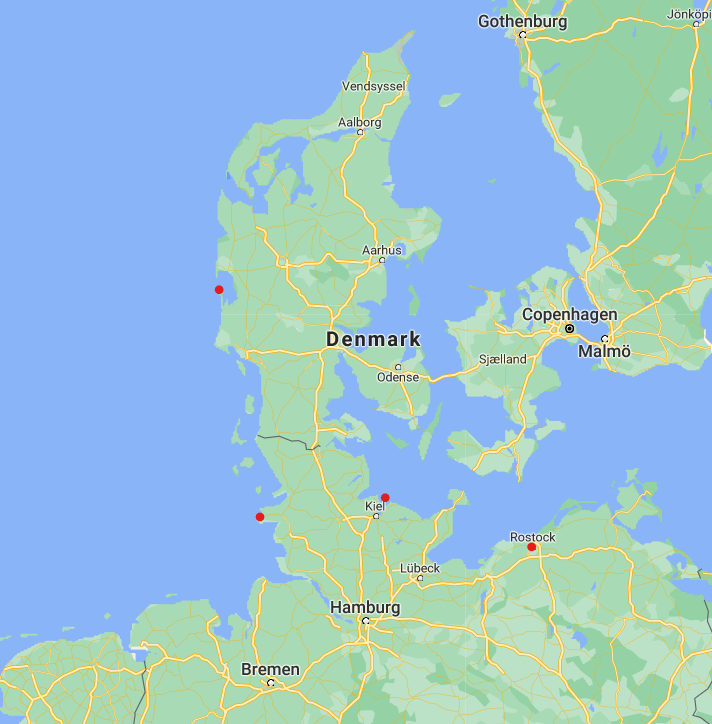

# **Preprocessing**

In [8]:
def is_float(value):
  try:
    float(value)
    return True
  except ValueError:
    return False

In [9]:
def get_data_and_date(weatherdata_list, index):
  if (len(weatherdata_list) <= index):
    return [], ""
  else:
    wd = weatherdata_list[index]
    date_in_wd = wd[0].split(":")[0]
    return wd, date_in_wd

In [10]:
def next_hour(date):
  the_time = dt.datetime.strptime(date, '%Y-%m-%d %H')
  new_time = the_time + dt.timedelta(hours=1)
  return new_time.strftime('%Y-%m-%d %H')

In [11]:
def get_avg_wind_dir(wind_speed, wind_dir, len):
  V_east = np.mean(wind_speed * np.sin(wind_dir * (np.pi / 180.)))
  V_north = np.mean(wind_speed * np.cos(wind_dir * (np.pi / 180.)))
  avg_wind_dir = math.atan2(np.sum(np.asarray(V_east)), np.sum(np.asarray(V_north))) * (180/np.pi)
  return (360 + avg_wind_dir) % 360

In [12]:
def avg_weather_per_hour_for_X(weatherdata_list):
  date = START_DATE
  wd_avg = []
  current_wind_speed = []
  current_wind_dir = []
  current_temperature = []
  data_index = 0
  data_counter = 0
  while date != END_DATE:
    wd, date_in_wd = get_data_and_date(weatherdata_list, data_index)
    while date_in_wd == date:
      current_wind_speed.append(float(wd[1] if is_float(wd[1]) else random.randint(2, 40)))
      current_wind_dir.append(float(wd[2] if is_float(wd[2]) else random.randint(0, 359)))
      current_temperature.append(float(wd[4] if is_float(wd[4]) else random.randint(0, 20)))
      data_index += 1
      data_counter += 1
      wd, date_in_wd = get_data_and_date(weatherdata_list, data_index)
    if data_counter > 0:
      current_wind_speed = np.asarray(current_wind_speed)
      current_wind_dir = np.asarray(current_wind_dir)
      current_temperature = np.asarray(current_temperature)
      avg_wind_speed = np.sum(current_wind_speed) / data_counter
      avg_wind_dir = get_avg_wind_dir(current_wind_speed, current_wind_dir, data_counter)
      avg_temperature = np.sum(current_temperature) / data_counter
      wd_avg.append([avg_wind_speed, avg_wind_dir, avg_temperature])
      current_wind_speed = []
      current_wind_dir = []
      current_temperature = []
      data_counter = 0
    else:
      wd_avg.append(wd_avg[len(wd_avg) - 1])
    date = next_hour(date)

  wd_avg = np.asarray(wd_avg)
  return wd_avg

In [13]:
def avg_weather_per_hour_for_Y(weatherdata_list):
  date = START_DATE
  wd_avg = []
  current_wind_speed = []
  current_wind_gust = []
  current_temperature = []
  data_index = 0
  data_counter = 0
  while date != END_DATE:
    wd, date_in_wd = get_data_and_date(weatherdata_list, data_index)
    while date_in_wd == date:
      current_wind_speed.append(float(wd[1] if is_float(wd[1]) else random.randint(1, 40)))
      current_wind_gust.append(float(wd[3] if is_float(wd[3]) else random.randint(2, 42)))
      current_temperature.append(float(wd[4] if is_float(wd[4]) else random.randint(0, 20)))
      data_index += 1
      data_counter += 1
      wd, date_in_wd = get_data_and_date(weatherdata_list, data_index)
    if data_counter > 0:
      current_wind_speed = np.asarray(current_wind_speed)
      current_wind_gust = np.asarray(current_wind_gust)
      current_temperature = np.asarray(current_temperature)
      avg_wind_speed = np.sum(current_wind_speed) / data_counter
      avg_wind_gust = np.sum(current_wind_gust) / data_counter
      avg_temperature = np.sum(current_temperature) / data_counter
      wd_avg.append([avg_wind_speed, avg_wind_gust, avg_temperature])
      current_wind_speed = []
      current_wind_gust = []
      current_temperature = []
      data_counter = 0
    else:
      wd_avg.append([np.nan] * 3)
    date = next_hour(date)

  wd_avg = np.asarray(wd_avg)
  return wd_avg

In [14]:
def get_wd_lists_array():
  wd_lists = []
  wd_lists.append(weatherdata_list_Kiel_Leuchtturm)
  wd_lists.append(weatherdata_list_Skt_Peter_Ording)
  wd_lists.append(weatherdata_list_Warnemuende_Wetterwarte)
  #wd_lists.append(weatherdata_list_Port_Said_Airport)
  #wd_lists.append(weatherdata_list_Molasses_Reef)
  #wd_lists.append(weatherdata_list_Renesse_West)
  wd_lists.append(weatherdata_list_Hvide_Sande)
  return wd_lists

In [15]:
# preprocessing for Kiel
def preprocessing():
  wd_lists = get_wd_lists_array()
  X_values = []
  print("Preprocessing started")
  for wd_list in wd_lists:
    X_values.append(avg_weather_per_hour_for_X(wd_list))
    print(".")
  X_values = np.asarray(X_values)
  Y_values = avg_weather_per_hour_for_Y(weatherdata_list_Kiel_Leuchtturm)
  print("Done. X_values.shape is {}, Y_values.shape is {}".format(X_values.shape, Y_values.shape))
  return X_values, Y_values

In [16]:
# get the values for X and Y
X_values, Y_values = preprocessing()

Preprocessing started
.
.
.
.
Done. X_values.shape is (4, 35064, 3), Y_values.shape is (35064, 3)


**Visualization**

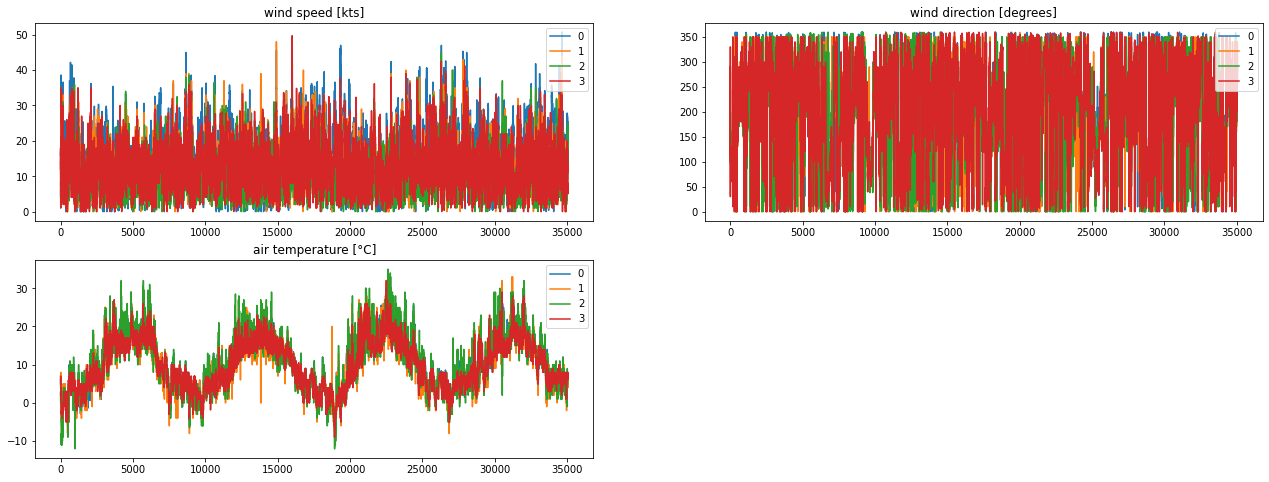

In [17]:
# visualization of all data that is used as input for training and testing
plt.figure(figsize=(22,8))
labels = ["wind speed [kts]", "wind direction [degrees]", "air temperature [°C]"]
for i in range(3):
  sp = plt.subplot(2,2,i+1)
  sp.title.set_text(labels[i])
  for j in range(0, num_locations):
    plt.plot(X_values[j,:,i], label=str(j))
  plt.legend(loc="upper right")

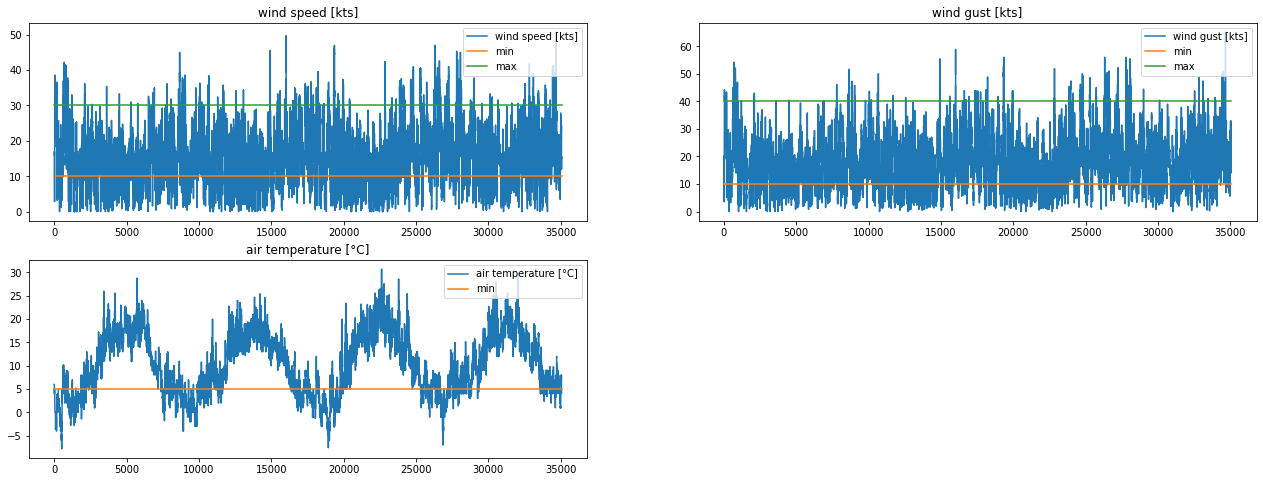

In [18]:
# show how the labels will be generated
plt.figure(figsize=(22,8))
labels = ["wind speed [kts]", "wind gust [kts]", "air temperature [°C]"]
x = [0, Y_values.shape[0]]
y_min = [min_wind_speed, min_wind_gust, min_temperature]
y_max = [max_wind_speed, max_wind_gust, max_temperature]
for i in range(3):
  sp = plt.subplot(2,2,i+1)
  sp.title.set_text(labels[i])
  plt.plot(Y_values[:,i], label=labels[i])
  y = [y_min[i]] * 2
  plt.plot(x, y, label="min")
  if i < 2:
    y = [y_max[i]] * 2
    plt.plot(x, y, label="max")
  plt.legend(loc="upper right")

**Prepare values for X and Y**

In [19]:
def nice_sailing_weather(wind_speed, wind_gust, temperature):
  wind_speed_ok = min_wind_speed <= wind_speed and wind_speed <= max_wind_speed
  wind_gust_ok = min_wind_gust <= wind_gust and wind_gust <= max_wind_gust
  temperature_ok = min_temperature <= temperature and temperature <= max_temperature
  return wind_speed_ok and wind_gust_ok and temperature_ok

In [20]:
def shuffle_in_unison(a, b):
  assert len(a) == len(b)
  shuffled_a = np.empty(a.shape, dtype=a.dtype)
  shuffled_b = np.empty(b.shape, dtype=b.dtype)
  permutation = np.random.permutation(len(a))
  for old_index, new_index in enumerate(permutation):
    shuffled_a[new_index] = a[old_index]
    shuffled_b[new_index] = b[old_index]
  return shuffled_a, shuffled_b

In [21]:
def get_X_and_Y(hours_per_X = 120, step_size = 2):
  X = []
  Y = []
  index = hours_per_X
  current_X = []
  while index + 24 < 35064:
    f_wd = Y_values[index + 24]
    if not np.isnan(f_wd[0]):
      current_X = X_values[:,index - hours_per_X:index,:]
      current_X_flattened = current_X.flatten()
      X.append(current_X_flattened)
      Y_label = [1] if nice_sailing_weather(f_wd[0], f_wd[1], f_wd[2]) else [0]
      Y.append(Y_label)
    index += step_size

  X = np.asarray(X)
  Y = np.asarray(Y)
  X, Y = shuffle_in_unison(X, Y)
  print("X_set.shape is {}, Y_set.shape is {}".format(X.shape, Y.shape))
  num_true_labels = np.sum(Y)
  print("{}% of the labels are 1".format(int(np.sum(Y) / Y.shape[0] * 100)))
  return X, Y

In [22]:
X_set, Y_set = get_X_and_Y()

X_set.shape is (16857, 1440), Y_set.shape is (16857, 1)
57% of the labels are 1


**Visualize input data**

In [23]:
# show flattened weatherdata
def show_weather(data):
  plt.figure(figsize=(16,8))
  labels = ["wind speed [kts]", "wind direction [degrees]", "air temperature [°C]"]
  values = data.reshape(num_locations, 120, 3)
  for i in range(3):
    sp = plt.subplot(2,2,i+1)
    sp.title.set_text(labels[i])
    for j in range(0, num_locations):
      plt.plot(values[j,:,i], label=str(j))
    plt.legend()

Weather for sailing 24h later was: NICE (label[1])


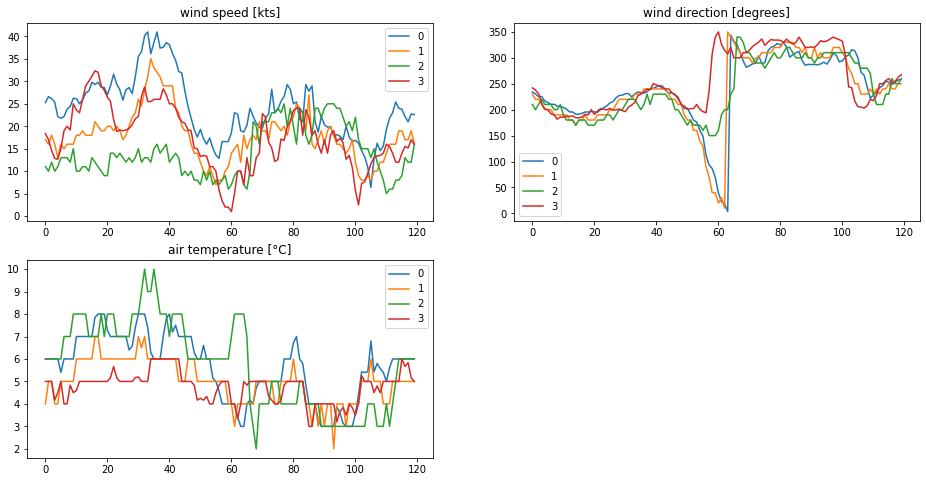

In [24]:
# example
index = 200
label = Y_set[index]
print("Weather for sailing 24h later was: {} (label{})".format("NICE" if label == 1 else "BAD", label))
show_weather(X_set[index])

# **Set train and test data**

In [25]:
m = len(X_set)
m_train = int(m * 0.95)
m_test = m - m_train
assert (m_train + m_test == m)
print("m = {}".format(m))
print("m_train = {}".format(m_train))
print("m_test = {}".format(m_test))
n_X = X_set.shape[1]
n_Y = 1
print("n_X = {}".format(n_X))
print("n_Y = {}".format(n_Y))
X_train = X_set[:m_train,:]
Y_train = Y_set[:m_train,:]
X_test = X_set[m_train:,:]
Y_test = Y_set[m_train:,:]
print("X_train.shape = {}".format(X_train.shape))
print("Y_train.shape = {}".format(Y_train.shape))
print("X_test.shape = {}".format(X_test.shape))
print("Y_test.shape = {}".format(Y_test.shape))

m = 16857
m_train = 16014
m_test = 843
n_X = 1440
n_Y = 1
X_train.shape = (16014, 1440)
Y_train.shape = (16014, 1)
X_test.shape = (843, 1440)
Y_test.shape = (843, 1)


In [27]:
# Calculate baseline
num_correct_labels = 0
for i in range(X_train.shape[0]):
  values = X_train[i].reshape(num_locations, 120, 3)
  label = Y_train[i] == 1
  values = X_train[i].reshape(num_locations, 120, 3)
  mean = np.mean(values[0], axis = 0)
  label_predict = nice_sailing_weather(mean[0], mean[0] * 1.4, mean[2])
  num_correct_labels += 1 if label == label_predict else 0
print("Baseline: {}%".format(int(num_correct_labels / m_train * 100)))

Baseline: 66%


# **Neural network implementation with Keras**

In [ ]:
# create model
model = tf.keras.Sequential(name="WindfinderModel")
model.add(tf.keras.Input(shape=(n_X,)))
model.add(tf.keras.layers.BatchNormalization(name="BN"))
model.add(tf.keras.layers.Dense(1000, activation="tanh", name="L1"))
model.add(tf.keras.layers.Dropout(0.5, name="D"))
model.add(tf.keras.layers.Dense(7, activation="relu", name="L2"))
model.add(tf.keras.layers.Dense(1, activation="sigmoid", name="L3"))
model.summary()

Model: "WindfinderModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
BN (BatchNormalization)      (None, 1440)              5760      
_________________________________________________________________
L1 (Dense)                   (None, 1000)              1441000   
_________________________________________________________________
D (Dropout)                  (None, 1000)              0         
_________________________________________________________________
L2 (Dense)                   (None, 7)                 7007      
_________________________________________________________________
L3 (Dense)                   (None, 1)                 8         
Total params: 1,453,775
Trainable params: 1,450,895
Non-trainable params: 2,880
_________________________________________________________________


In [ ]:
# compile model
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

### Train the model

Epoch 1/70
12/12 [==============================] - 4s 237ms/step - loss: 1.0530 - accuracy: 0.5901
Epoch 2/70
12/12 [==============================] - 3s 231ms/step - loss: 0.6511 - accuracy: 0.6739
Epoch 3/70
12/12 [==============================] - 3s 233ms/step - loss: 0.5765 - accuracy: 0.7038
Epoch 4/70
12/12 [==============================] - 3s 235ms/step - loss: 0.5544 - accuracy: 0.7186
Epoch 5/70
12/12 [==============================] - 3s 234ms/step - loss: 0.5391 - accuracy: 0.7274
Epoch 6/70
12/12 [==============================] - 3s 234ms/step - loss: 0.5184 - accuracy: 0.7398
Epoch 7/70
12/12 [==============================] - 3s 233ms/step - loss: 0.5006 - accuracy: 0.7481
Epoch 8/70
12/12 [==============================] - 3s 234ms/step - loss: 0.4838 - accuracy: 0.7605
Epoch 9/70
12/12 [==============================] - 3s 233ms/step - loss: 0.4574 - accuracy: 0.7747
Epoch 10/70
12/12 [==============================] - 3s 233ms/step - loss: 0.4491 - accuracy: 0.7839

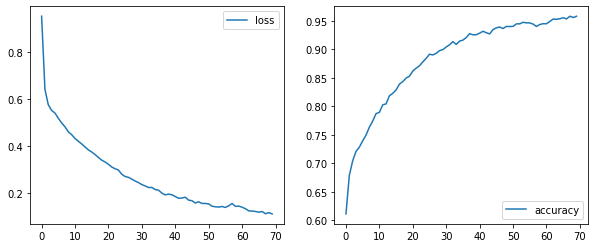

In [ ]:
# train model with training data
history = model.fit(x = X_train, y = Y_train, epochs = 70, batch_size = n_X)
# show history
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='loss')
plt.legend(loc="upper right")
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='accuracy')
plt.legend(loc="lower right")
plt.show()

In [ ]:
# save or load a trained model
#model.save('windfinder_model')
#model = keras.models.load_model("windfinder_model")

# **Tests**

In [ ]:
# test model with test data
preds = model.evaluate(x = X_test, y = Y_test)
print("loss: " + str(preds[0]))
print("test accuracy: " + str(preds[1]))

27/27 [==============================] - 0s 4ms/step - loss: 0.3815 - accuracy: 0.8600
loss: 0.3814963102340698
test accuracy: 0.8600237369537354


In [ ]:
# select data (0 <= index < m_test)
index = 300
wd = X_test[index]
wd = wd[:, np.newaxis]
print("wd.shape = {}".format(wd.shape))

wd.shape = (1440, 1)


In [ ]:
# predict
print("predict label for data at index {}".format(index))
label = Y_test[index]
prediction = model.predict(tf.convert_to_tensor(wd.T))[0]
print("-> label: {}, prediction: {}".format(label, prediction))
print("-> {}".format("Correct" if abs(label - prediction) < 0.5 else "Wrong"))

predict label for data at index 300
-> label: [1], prediction: [0.9930364]
-> Correct


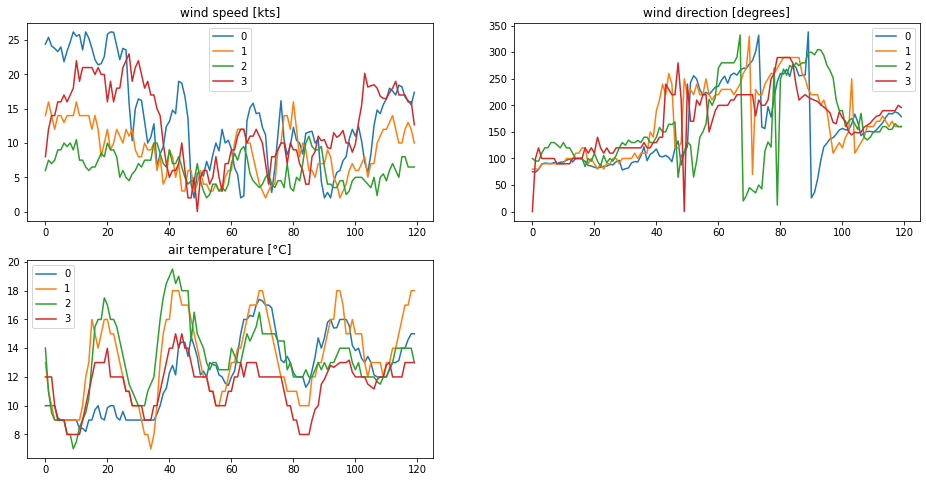

In [ ]:
show_weather(wd)

# **Conclusion**

This is a prototype.

**Next steps for improvement:**

1.   Use data from more locations
2.   Further optimization of the neural network

